In [1]:
!pip install transformers

In [2]:
import os
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import spacy
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

In [3]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#files
folder_id = "1iCxALYgJnqDJRhXwEWUOQfwpFu5qvrvG"
documents = []
file_names = []

folder = drive.CreateFile({'id': folder_id})

file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()


for file in file_list:
    if file['title'].endswith(".txt"):
        file.GetContentFile(file['title'])
        filename = file['title']

        with open(file['title'], "r", encoding="utf-8") as f:
            text = f.read()
            documents.append(text)
            file_names.append(filename)

This code loads a pre-trained BERT model and tokenizer, then uses them to create embeddings for a list of documents. Embeddings are numerical representations of text that capture the meaning of documents, making it easier for a machine learning algorithm to analyze or group them.

First, the code loads the BERT model (bert-base-uncased), which is a commonly-used model trained to understand English text without distinguishing between uppercase and lowercase letters. It also loads the tokenizer, which is needed to convert text into tokens (small parts like words or parts of words) that the model can understand.

Then, the code defines a function to generate embeddings. This function processes each document separately: it converts the document into tokens, passes them into the BERT model, and then calculates the average embedding across all tokens. The resulting embedding represents the overall meaning of the document.

Finally, the function is used to generate embeddings for the documents, and these embeddings can be used for tasks like clustering or classifying texts.

In [5]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to get BERT embeddings for a list of documents
def get_bert_embeddings(documents):
  embeddings = []
  for doc in documents:
    inputs = tokenizer(doc, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy()[0])
  return embeddings

# Get BERT embeddings for your documents
embeddings = get_bert_embeddings(documents)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<ipython-input-6-037cc088a1ac>:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_embeddings[i][0], reduced_embeddings[i][1], c=plt.cm.Set1(labels[i]))


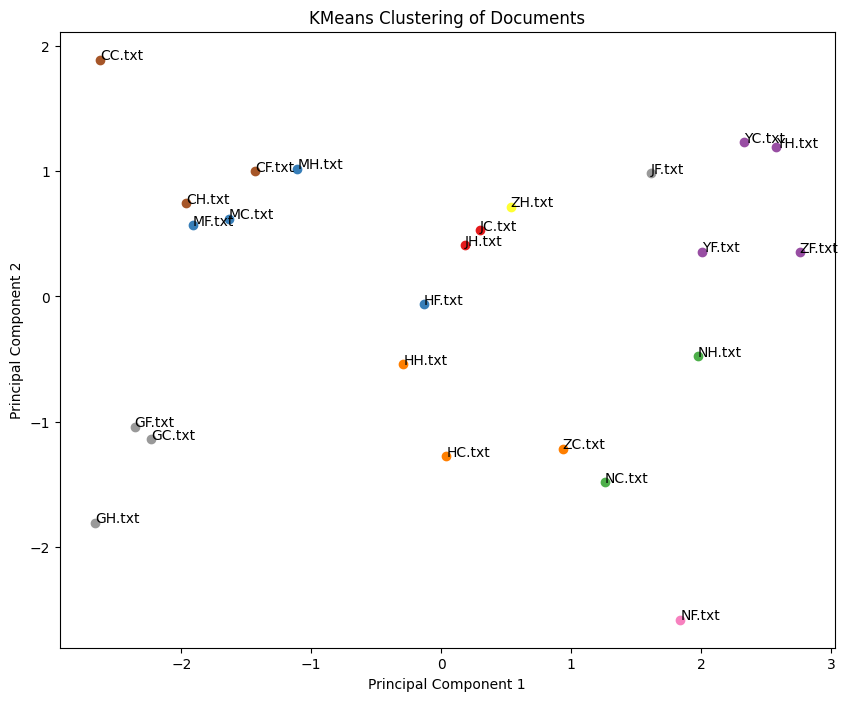

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(embeddings)
labels = kmeans.labels_

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for i in range(len(labels)):
  plt.scatter(reduced_embeddings[i][0], reduced_embeddings[i][1], c=plt.cm.Set1(labels[i]))
  plt.annotate(file_names[i], (reduced_embeddings[i][0], reduced_embeddings[i][1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering of Documents')

plt.show()



## Clustering Results

Here's a summary of the clustering performance based on the provided metrics:

* **Inertia:** 76.67
    * Represents the sum of squared distances of samples to their closest cluster center.
    * Lower inertia generally indicates better clustering, as it means data points are closer to their assigned cluster centroids.
* **Davies-Bouldin Index:** 1.07
    * Measures the average similarity between each cluster and its most similar cluster.
    * Lower values indicate better clustering.
    * A score of 1.07 suggests moderate cluster separation.

**Overall Interpretation:**

The clustering results show moderate performance. The inertia is relatively high, indicating that the data points within clusters are not very close to their centroids. The silhouette score is low, suggesting that the clusters are not well-defined and that there might be some overlap between them. The Davies-Bouldin index is also moderate, indicating that clusters are not very distinct from each other.

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
# Calculate inertia for each cluster
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")



# Calculate Davies-Bouldin Index
davies_bouldin_index = davies_bouldin_score(embeddings, labels)
print(f"Davies-Bouldin Index: {davies_bouldin_index}")


Inertia: 76.66790089690026
Davies-Bouldin Index: 1.068556535436483
